# 2. EDA

In [1]:
import geopandas as gpd
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
EXTERNAL_DATA = os.path.join(DATA, "external") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
REPORTS = os.path.join(ROOT, "reports")
FIGURES = os.path.join(REPORTS, "figures")


In [3]:
df = gpd.read_parquet(
    os.path.join(INTERIM_DATA, 'df_geo_etl.geoparquet.gzip')
)
df

,created_at,start_date,start_hour,end_date,end_hour,lor,price,attempt,bicycle_type,group,...,age_14_15,age_15_18,age_18_21,age_25_27,age_55_60,age_60_64,age_80_85,poi_cnt,area_km2,poi_density_km2
0,2025-02-11,2025-10-31,15,2025-10-31,16,07601546,999,1,step_through,bicycle_theft,...,73.0,177.0,218.0,119.0,616.0,368.0,372.0,6.0,1.773447,3.383241
1,2025-02-11,2025-11-01,12,2025-11-01,18,01200522,1500,1,diamond_frame,bicycle_theft,...,76.0,234.0,294.0,385.0,772.0,554.0,305.0,128.0,0.639144,200.267843
2,2025-02-11,2025-11-01,0,2025-11-01,0,01300836,100,1,diamond_frame,cellar_attic_burglary,...,146.0,439.0,531.0,645.0,761.0,448.0,226.0,100.0,1.440714,69.410022
3,2025-02-11,2025-11-02,14,2025-11-02,16,03601243,240,1,mtb,bicycle_theft,...,55.0,127.0,114.0,213.0,462.0,207.0,119.0,71.0,0.329525,215.461750
4,2025-02-11,2025-10-22,12,2025-10-22,20,04501153,399,1,diamond_frame,bicycle_theft,...,56.0,231.0,185.0,245.0,510.0,288.0,217.0,65.0,0.585827,110.954225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35724,2024-02-01,2024-01-01,16,2024-01-01,20,04500938,1189,1,kids,bicycle_theft,...,53.0,168.0,177.0,244.0,598.0,315.0,359.0,23.0,0.517514,44.443283
35725,2024-02-01,2024-01-01,17,2024-01-02,12,04400727,2900,1,diamond_frame,bicycle_theft,...,59.0,173.0,192.0,221.0,593.0,389.0,430.0,19.0,0.914526,20.775792
35726,2024-01-01,2024-01-01,14,2024-01-01,16,06300632,899,1,multiple,bicycle_theft,...,173.0,484.0,468.0,249.0,1222.0,678.0,645.0,14.0,3.084440,4.538911
35727,2024-01-01,2024-01-01,19,2024-01-01,19,10300731,1,1,multiple,bicycle_theft,...,64.0,185.0,177.0,211.0,614.0,456.0,426.0,32.0,2.739947,11.679059


## Overall damage sum

In [4]:
df['created_at'].max(), df['created_at'].min(), df['price'].sum()

(Timestamp('2025-12-10 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 np.int64(45126876))

In [5]:
print(f"For the period from {df['created_at'].min().strftime("%d-%m-%Y")} to {df['created_at'].max().strftime("%d-%m-%Y")} overall damange is €{df['price'].sum():,.3f}")

For the period from 01-01-2024 to 10-12-2025 overall damange is €45,126,876.000


## Number of thefts

In [6]:
df.shape[0]

35729

## Number of thefts per district name:

In [7]:
df.groupby('bez_name')['created_at'].count().sort_values(ascending=False)

bez_name
Mitte                         2466
Friedrichshain-Kreuzberg      1786
Pankow                        1628
Charlottenburg-Wilmersdorf    1422
Tempelhof-Schöneberg          1158
Neukölln                      1101
Treptow-Köpenick              1079
Steglitz-Zehlendorf            893
Lichtenberg                    837
Reinickendorf                  529
Marzahn-Hellersdorf            365
Spandau                        354
Name: created_at, dtype: int64

<Axes: xlabel='bez_name'>

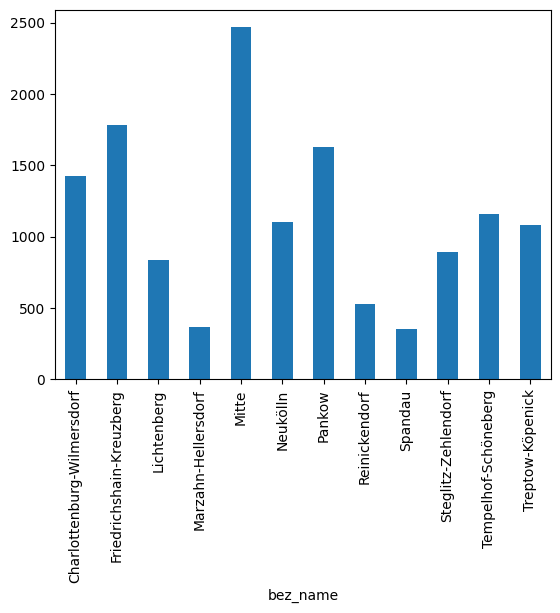

In [8]:
df.groupby('bez_name')['created_at'].count().plot(kind='bar')

* Most of the thefts happen in:
  * Mitte
  * Friedrichshain-Kreuzberg
  * Pankow

## Display number of thefts per LOR on map

In [9]:
df.groupby('lor')['created_at'].count().sort_values(ascending=False)

lor
09100101    165
01100308    134
02300419    125
01100309    124
01100415    103
           ... 
05200632      0
07501135      0
10200419      0
04400725      0
10100205      0
Name: created_at, Length: 537, dtype: int64

In [10]:
import json
import geopandas as gpd
from shapely.geometry import mapping
from ipyleaflet import Map, Choropleth, LayersControl, FullScreenControl, DivIcon, Marker, LayerGroup
from IPython.display import HTML as _HTML
from ipyleaflet import Popup
from ipywidgets import HTML
from branca.colormap import linear

counts = (df.groupby("lor")["created_at"]
              .count()
              .astype(float))

polys = (df[["lor", "geometry"]]
         .dropna(subset=["geometry"])
         .drop_duplicates(subset=["lor"])
         .copy())
polys = gpd.GeoDataFrame(polys, geometry="geometry",
                         crs=(df.crs if getattr(df, "crs", None) else 25833))

polys["lor"] = polys["lor"].astype(str).str.zfill(8)
counts.index = counts.index.astype(str).str.zfill(8)
if polys.crs is None:
    polys = polys.set_crs(25833)
polys4326 = polys.to_crs(4326)
gj = json.loads(polys4326.rename(columns={"lor": "id"}).to_json())

# 1) Геометрия по одному полигону на LOR + нужная CRS
polys = (df[["lor", "geometry"]]
         .dropna(subset=["geometry"])
         .drop_duplicates(subset=["lor"])
         .copy())
polys["lor"] = polys["lor"].astype(str).str.zfill(8)
if getattr(polys, "crs", None) is None:
    polys = gpd.GeoDataFrame(polys, geometry="geometry", crs=25833)
polys4326 = polys.to_crs(4326)

pts = polys4326.geometry.representative_point()
labels = polys4326.assign(lat=pts.y, lon=pts.x).join(counts.rename("cnt"), on="lor").fillna({"cnt":0})

_HTML("""
<style>
.count-label{
  background: transparent !important;
  border: none !important;
  box-shadow: none !important;
}
</style>
""")

def label_html(v:int) -> str:
    return DivIcon(
        class_name="count-label",   # важно: свой класс, не 'leaflet-div-icon'
        icon_size=(1, 1),
        html=f"""
        <span style="font: 700 12px/1 -apple-system, Segoe UI, Roboto, sans-serif;
                     color:#111;
                     text-shadow:
                      -1px -1px 0 rgba(255,255,255,.9),
                       1px -1px 0 rgba(255,255,255,.9),
                      -1px  1px 0 rgba(255,255,255,.9),
                       1px  1px 0 rgba(255,255,255,.9);">
          {int(v)}
        </span>"""
    )

markers = [Marker(location=(r.lat, r.lon), icon=label_html(r.cnt))
           for _, r in labels.iterrows()]


features = []
for _, row in polys4326.iterrows():
    lor_id = row["lor"]
    features.append({
        "type": "Feature",
        "id": lor_id,                      # <-- ВАЖНО: top-level id = LOR
        "properties": {"lor": lor_id},
        "geometry": mapping(row.geometry)
    })
gj = {"type": "FeatureCollection", "features": features}

counts = (df.groupby("lor")["created_at"].count()
          .astype(float))
counts.index = counts.index.astype(str).str.zfill(8)
choro_data = counts.to_dict()

vmin, vmax = min(choro_data.values()), max(choro_data.values())
cmap = linear.YlOrRd_09.scale(vmin, vmax)

# 4) Рендер
m = Map(center=(52.52, 13.405), zoom=12)
m.add_control(FullScreenControl()); m.add_control(LayersControl())
labels_layer = LayerGroup(layers=markers, name="Number of thefts")

counts_dict = counts.to_dict()

def on_click(**kwargs):
    props = kwargs.get("properties", {})
    lor_id = props.get("lor")
    if lor_id is None:
        return
    val = int(counts_dict.get(str(lor_id).zfill(8), 0))
    loc = kwargs.get("coordinates")  # [lat, lon] точки клика

    html = HTML()
    html.value = f"<b>LOR {lor_id}</b><br>Thefts: {val}"
    m.add_layer(Popup(location=loc, child=html, close_button=True,
                      auto_close=True, close_on_escape_key=True))

choro = Choropleth(
    geo_data=gj,
    choro_data=choro_data,
    colormap=cmap,
    value_min=vmin, value_max=vmax,
    style={"color": "black", "weight": 0.3, "fillOpacity": 0.8},
    name="Thefts per LOR"
)
choro.on_click(on_click)
m.add_layer(choro)
m.add_layer(labels_layer)

minx, miny, maxx, maxy = polys4326.total_bounds
m.fit_bounds([[miny, minx], [maxy, maxx]])
m.save(os.path.join(REPORTS, "eda_thefts_per_lor_map.html"))
m

Map(center=[52.52, 13.405], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [11]:
df['created_at'].max()

Timestamp('2025-12-10 00:00:00')

## 1. Base metrics

In [12]:
df = df.copy()
df["lor"] = df["lor"].astype(str).str.zfill(8)
df["date"] = pd.to_datetime(df["start_date"]).dt.normalize()

daily = (df.groupby(["date","lor"]).size()
         .rename("y_count").reset_index())

pop = (df[["lor","population_total"]]
       .dropna().drop_duplicates("lor"))
daily = daily.merge(pop, on="lor", how="left")
daily["y_rate_per_1000"] = daily["y_count"] / daily["population_total"] * 1000

city_pop = pop["population_total"].sum()
city = (daily.groupby("date")["y_count"].sum()
        .rename("city_count").reset_index())
city["city_rate_per_1000"] = city["city_count"] / city_pop * 1000

### Number of thefts per day

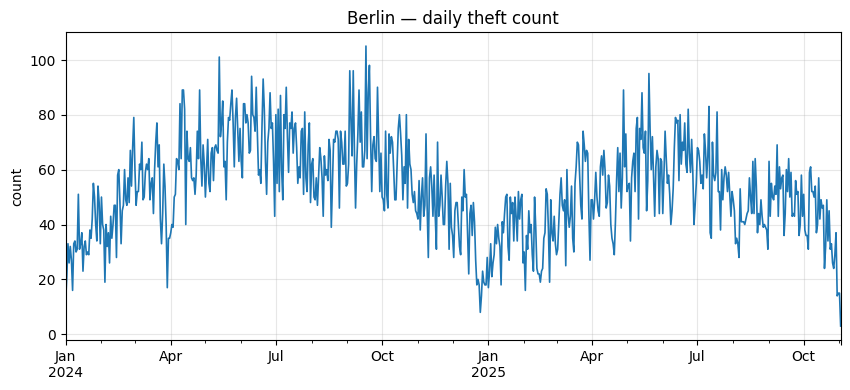

In [13]:
plt.figure(figsize=(10,4))
ax = city.set_index("date")["city_count"].plot(linewidth=1.2)
ax.set_title("Berlin — daily theft count")
ax.set_xlabel("")
ax.set_ylabel("count")
ax.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIGURES, "eda_daily_theft_count.png"))
plt.show()

### Number of thefts per 1000 of population

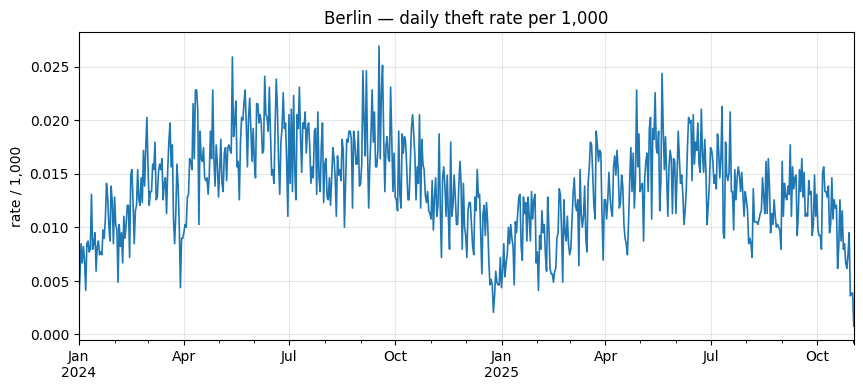

In [14]:
plt.figure(figsize=(10,4))
ax = city.set_index("date")["city_rate_per_1000"].plot(linewidth=1.2)
ax.set_title("Berlin — daily theft rate per 1,000")
ax.set_xlabel("")
ax.set_ylabel("rate / 1,000")
ax.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIGURES, "eda_daily_theft_rate_per_1000_population.png"))
plt.show()

### Daily theft count with rolling mean (7 days)

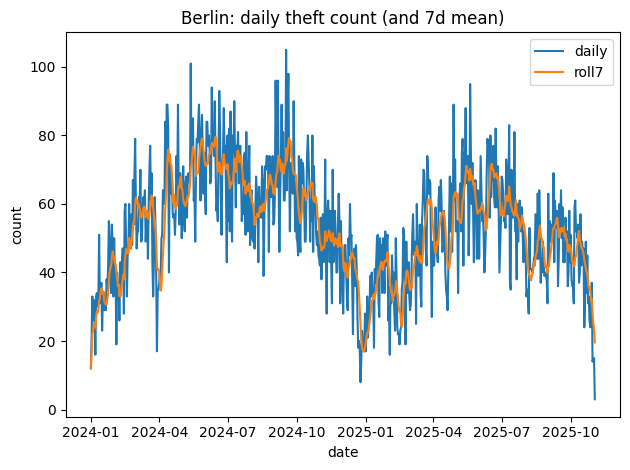

In [15]:
plt.figure()
tmp = city.copy()
tmp["roll7"] = tmp["city_count"].rolling(7, min_periods=1).mean()
plt.plot(tmp["date"], tmp["city_count"], label="daily")
plt.plot(tmp["date"], tmp["roll7"], label="roll7")
plt.title("Berlin: daily theft count (and 7d mean)")
plt.xlabel("date")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES, "eda_daily_theft_count_with_rolling_mean.png"))
plt.show()

In [16]:
s = city.copy()
s = s.sort_values("date").set_index("date")
s["roll7"] = s["city_count"].rolling(7, center=True, min_periods=3).mean()
s["std14"] = s["city_count"].rolling(14, center=True, min_periods=7).std()
s["z"] = (s["city_count"] - s["roll7"]) / s["std14"]

peaks  = s[s["z"] >= 2].reset_index().sort_values("z", ascending=False)
troughs = s[s["z"] <= -2].reset_index().sort_values("z")

print("TOP spikes (z>=2):")
print(peaks[["date","city_count","roll7","z"]].head(10))
print("\nTOP dips (z<=-2):")
print(troughs[["date","city_count","roll7","z"]].head(10))

TOP spikes (z>=2):
        date  city_count      roll7         z
1 2024-04-26          89  67.428571  2.105652
3 2025-09-01          63  45.571429  2.056175
2 2024-11-08          73  50.142857  2.051859
0 2024-01-12          51  35.285714  2.051373

TOP dips (z<=-2):
        date  city_count      roll7         z
0 2024-04-14          40  71.571429 -2.247648
1 2024-11-10          28  52.285714 -2.170368
2 2025-02-23          19  40.142857 -2.035249


In [17]:
import holidays

dates = pd.to_datetime([
    "2024-04-26",
    "2025-09-01",
    "2024-11-08",
    "2024-01-12",
    "2024-04-14",
    "2024-11-10",
    "2025-02-23"
])

weather_cols = ["precipitation_sum","temperature_2m_mean","sunshine_h"]
ctx = (df.assign(date=pd.to_datetime(df["start_date"]).dt.normalize())
         .groupby("date")[weather_cols].mean()
         .reindex(dates))

de_be = holidays.Germany(prov="BE", years=sorted(dates.year.unique()))
out = pd.DataFrame(index=dates)
out["dow"] = out.index.day_name()
out["is_holiday"] = [int(d.date() in de_be) for d in out.index]
out = out.join(ctx)

print(out)

               dow  is_holiday  precipitation_sum  temperature_2m_mean  \
2024-04-26  Friday           0           5.775000             3.937500   
2025-09-01  Monday           0           4.110000             2.848333   
2024-11-08  Friday           0           0.272308            12.838462   
2024-01-12  Friday           0           0.044444             1.683333   
2024-04-14  Sunday           0                NaN                  NaN   
2024-11-10  Sunday           0           0.342857             5.147619   
2025-02-23  Sunday           0           0.100000            16.700000   

            sunshine_h  
2024-04-26    1.481401  
2025-09-01    6.649530  
2024-11-08    4.892731  
2024-01-12    6.367907  
2024-04-14         NaN  
2024-11-10    4.007398  
2025-02-23   10.705451  


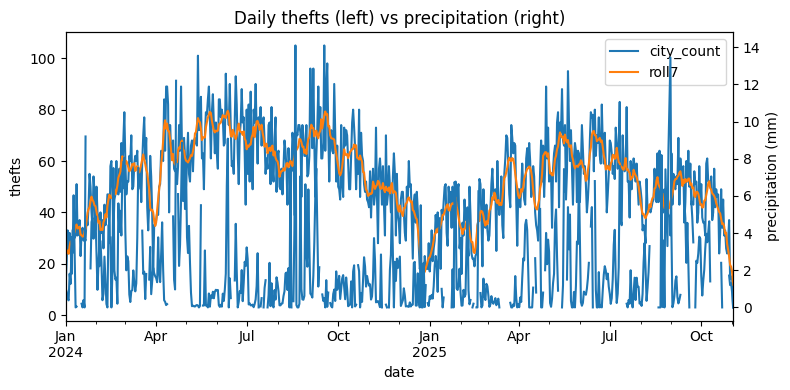

In [18]:
df = df.copy()
df["date"] = pd.to_datetime(df["start_date"]).dt.normalize()

city = (df.groupby("date").size()
          .rename("city_count")
          .to_frame())

city["roll7"] = city["city_count"].rolling(7, min_periods=1).mean()

prec_by_date = (df.groupby("date")["precipitation_sum"]
                  .mean()
                  .rename("precipitation_sum"))

cw = s[["city_count","roll7"]].join(prec_by_date)

ax = cw[["city_count","roll7"]].plot(figsize=(8,4))
ax.set_xlabel("date")
ax.set_ylabel("thefts")
ax2 = ax.twinx()
cw["precipitation_sum"].plot(ax=ax2)
ax2.set_ylabel("precipitation (mm)")
ax.set_title("Daily thefts (left) vs precipitation (right)")
plt.savefig(
    os.path.join(FIGURES, "eda_daily_theft_vs_precipitation.png")
)
plt.tight_layout()

#### Observations

* Season correlation
  * More thefts on summer
  * Less on winter
* Not that much correlation with precipitation

## 2. Calendar

### Prepare data

In [19]:
daily["dow"] = daily["date"].dt.dayofweek     # 0=Mon..6=Sun
daily["month"] = daily["date"].dt.month

rate_by_dow = (daily.groupby("dow")["y_rate_per_1000"]
               .count().reindex(range(7)))
rate_by_month = (daily.groupby("month")["y_rate_per_1000"]
                 .count().reindex(range(1,13)))
events_by_hour = (df.groupby("start_hour").size()
                  .reindex(range(24), fill_value=0))

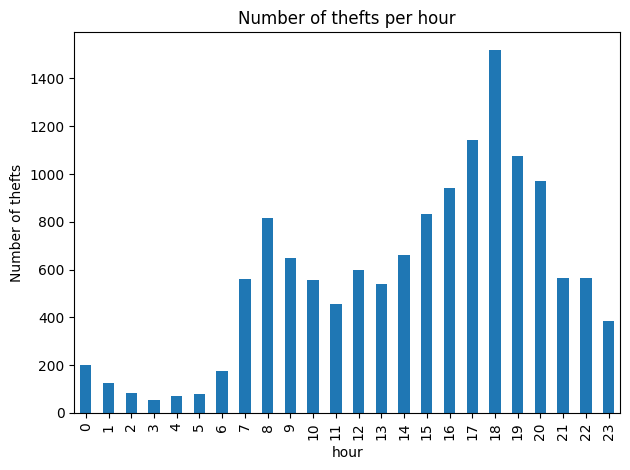

In [20]:
thefts_per_hour = df.groupby('start_hour')['created_at'].count()
plt.figure()
thefts_per_hour.plot(kind='bar')
plt.title("Number of thefts per hour")
plt.xlabel("hour")
plt.ylabel("Number of thefts")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_theft_per_hour.png")
)
plt.show()

### Rate by day of week

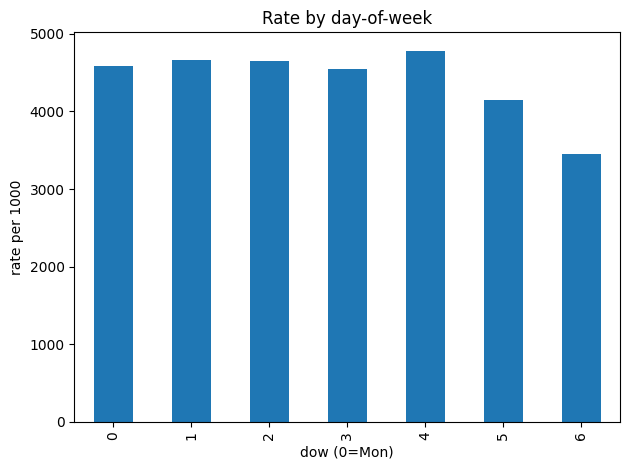

In [21]:
plt.figure()
rate_by_dow.plot(kind="bar")
plt.title("Rate by day-of-week")
plt.xlabel("dow (0=Mon)")
plt.ylabel("rate per 1000")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_theft_rate_by_day_of_week.png")
)
plt.show()

### Rate by month

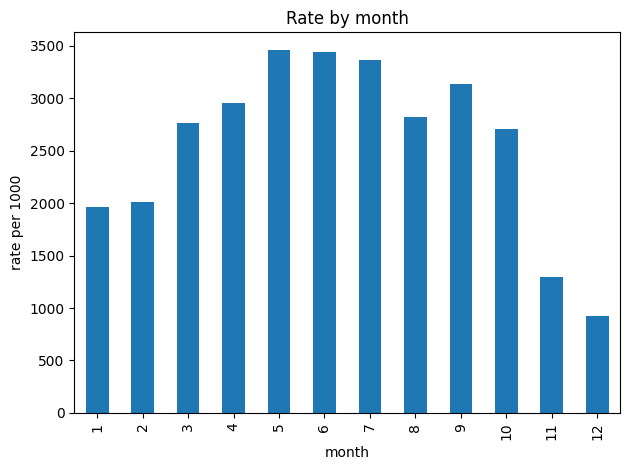

In [22]:
plt.figure()
rate_by_month.plot(kind="bar")
plt.title("Rate by month")
plt.xlabel("month")
plt.ylabel("rate per 1000")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_theft_rate_by_month.png")
)
plt.show()

### Events by start hour

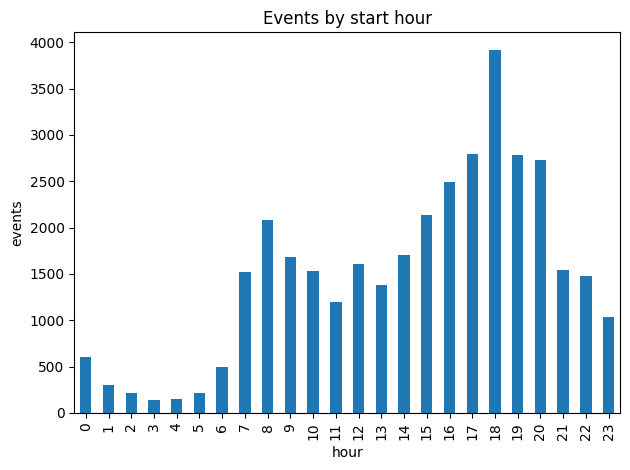

In [23]:
plt.figure()
events_by_hour.plot(kind="bar")
plt.title("Events by start hour")
plt.xlabel("hour")
plt.ylabel("events")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_thefts_by_start_hour.png")
)
plt.show()

### Number of thefts for each 'group' value:

In [24]:
df['group'].unique()

array(['bicycle_theft', 'cellar_attic_burglary'], dtype=object)

In [25]:
df[df['group'] == 'bicycle_theft'].groupby('lor')['created_at'].count().sort_values(ascending=False)

lor
09100101    159
01100308    134
02300419    124
01100309    116
01100415    101
           ... 
10100207      0
12601031      0
10200419      0
07501135      0
08401245      0
Name: created_at, Length: 537, dtype: int64

In [26]:
df[df['group'] == 'cellar_attic_burglary'].groupby('lor')['created_at'].count().sort_values(ascending=False)

lor
03601245    11
11400929     9
10200629     9
01100309     8
01400937     8
            ..
08401242     0
08401241     0
08401140     0
05200632     0
06300524     0
Name: created_at, Length: 425, dtype: int64

#### Observations

* There are 112 lor, where no `cellar_attic_burglary` thefts happening

## 3. Top-20 LOR for rate per 1000

In [27]:
daily = daily.copy()
daily["population_total"] = daily["population_total"].replace(0, np.nan)
daily["y_rate_per_1000"] = (
    daily["y_count"] / daily["population_total"] * 1000.0
)

# Remove inf
daily["y_rate_per_1000"] = daily["y_rate_per_1000"].replace([np.inf, -np.inf], np.nan)

lor_rate_mean = (daily.groupby("lor")["y_rate_per_1000"]
                       .mean()
                       .dropna()
                       .sort_values(ascending=False)
                       .head(20))
lor_rate_mean

lor
04400725    16.393443
05300840     2.130077
08200728     0.932836
03300517     0.919118
04200203     0.883046
02400625     0.876101
05200422     0.832639
10100205     0.819001
04200205     0.793021
01100206     0.677653
10200421     0.656714
04400831     0.648088
09401432     0.636132
09401330     0.616815
05200419     0.612745
05400944     0.610780
01100102     0.602957
09301227     0.539957
08200729     0.535045
05200633     0.529346
Name: y_rate_per_1000, dtype: float64

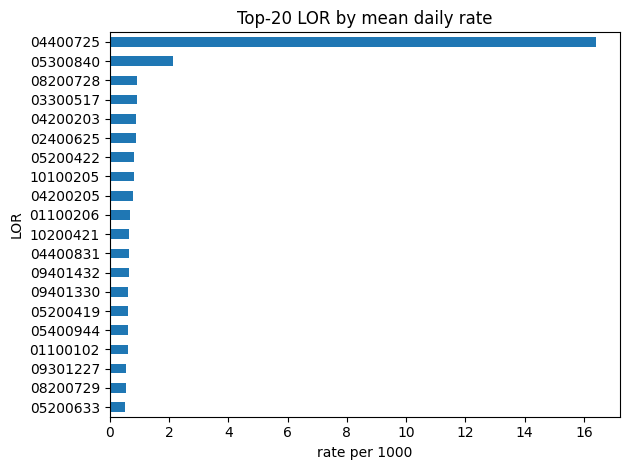

In [28]:
plt.figure()
lor_rate_mean.iloc[::-1].plot(kind="barh")
plt.title("Top-20 LOR by mean daily rate")
plt.xlabel("rate per 1000")
plt.ylabel("LOR")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_top_20_lor_mean_daily_rate.png")
)
plt.show()

#### Observations

* Top LOR belongs to `Pankow` district

## 4. Map for thefts rate per 1000 for each LOR

In [29]:
from shapely.geometry import mapping

# Geometry per LOR
polys = (df[["lor","geometry"]]
         .dropna(subset=["geometry"])
         .drop_duplicates("lor").copy())

gdf = gpd.GeoDataFrame(polys, geometry="geometry")
if gdf.crs is None:
    gdf = gdf.set_crs(25833)  # LOR in meters EPSG:25833
gdf4326 = gdf.to_crs(4326)

# mean rate for LOR
rate_mean_all = daily.groupby("lor")["y_rate_per_1000"].mean()
rate_mean_all.index = rate_mean_all.index.astype(str).str.zfill(8)
choro_data = {k: float(v) for k, v in rate_mean_all.to_dict().items()}

# GeoJSON with top-level id = LOR
features = []
for _, row in gdf4326.iterrows():
    lor_id = str(row["lor"]).zfill(8)
    features.append({
        "type":"Feature", "id": lor_id,
        "properties":{"lor": lor_id},
        "geometry": mapping(row.geometry)
    })
gj = {"type":"FeatureCollection","features": features}

In [30]:
import numpy as np
from ipyleaflet import Map, Choropleth, FullScreenControl, LayersControl
from branca.colormap import linear

vals = np.array(list(choro_data.values()), dtype=float)
vals = vals[np.isfinite(vals)]
assert vals.size > 0, "No valid choloropleth values"

vmin = float(np.nanmin(vals))
vmax = float(np.nanmax(vals))
if not np.isfinite(vmin) or not np.isfinite(vmax):
    raise ValueError("vmin/vmax нечисловые — проверь choro_data")

# If all values are equal - expand the domain
if vmin == vmax:
    eps = 1e-9 if vmin == 0 else abs(vmin) * 1e-6
    vmin, vmax = vmin - eps, vmin + eps

# Sort steps
idx = np.linspace(vmin, vmax, 9).tolist()
cmap = linear.YlOrRd_09.to_step(index=idx)

ids_geo = {f["id"] for f in gj["features"]}
ids_data = set(choro_data.keys())


m = Map(center=(52.52, 13.405), zoom=11)
m.add_control(FullScreenControl()); m.add_control(LayersControl())

choro = Choropleth(
    geo_data=gj,
    choro_data=choro_data,
    colormap=cmap,
    value_min=vmin, value_max=vmax,
    style={"color": "black", "weight": 0.3, "fillOpacity": 0.8},
    name="Mean rate per LOR"
)
m.add_layer(choro)

minx, miny, maxx, maxy = gdf4326.total_bounds
m.fit_bounds([[miny, minx], [maxy, maxx]])
m

Map(center=[52.52, 13.405], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [31]:
choro_data

{'01100101': 0.3012378135611787,
 '01100102': 0.6029572735199719,
 '01100103': 0.20520186733699275,
 '01100104': 0.23863094020590442,
 '01100205': 0.37852816820934754,
 '01100206': 0.6776527695867168,
 '01100207': 0.13498399475490763,
 '01100308': 0.19807374668420663,
 '01100309': 0.10272667312468617,
 '01100310': 0.12553273553558636,
 '01100311': 0.1190576674470571,
 '01100312': 0.10624646987535576,
 '01100313': 0.10298087895571822,
 '01100414': 0.2200078407049613,
 '01100415': 0.09457418621694355,
 '01100416': 0.09012423278858242,
 '01200517': 0.2885003750504876,
 '01200518': 0.15373577944040173,
 '01200519': 0.10955457231308577,
 '01200520': 0.1291465813698548,
 '01200521': 0.21797707994193463,
 '01200522': 0.106689234152128,
 '01200623': 0.1131019703553783,
 '01200624': 0.17169680091028405,
 '01200625': 0.14927867208823034,
 '01200626': 0.19830226222319372,
 '01200627': 0.33732501264968795,
 '01200628': 0.3356494430919872,
 '01200629': 0.18283932218358448,
 '01300730': 0.1393395686

## 5. Weather

### Prepare data

In [32]:
df2 = df.copy()
df2["date"] = pd.to_datetime(df2["start_date"]).dt.normalize()

city_count = df2.groupby("date").size().rename("city_count")

weather_cols = ["precipitation_sum","temperature_2m_mean","sunshine_h"]
weather_daily = df2.groupby("date")[weather_cols].mean()


cw = pd.concat([city_count, weather_daily], axis=1).sort_index()
city_pop = (df2[["lor","population_total"]]
            .dropna().drop_duplicates("lor")["population_total"].sum())
city_pop = max(city_pop, 1.0)

cw["rate"] = cw["city_count"] / city_pop * 1000.0
cw["rate_roll7"] = cw["rate"].rolling(7, min_periods=1).mean()

bins = [0, 0.1, 1, 3, 10, np.inf]  # мм
labels = ["dry","drizzle","light","moderate","heavy"]
cw["prec_bin"] = pd.cut(cw["precipitation_sum"].fillna(0), bins=bins, labels=labels, right=False)

### Mean city rate vs precipitation bin plot

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_34808/345303811.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (cw.groupby("prec_bin")["rate"].mean().reindex(labels)).plot(kind="bar")


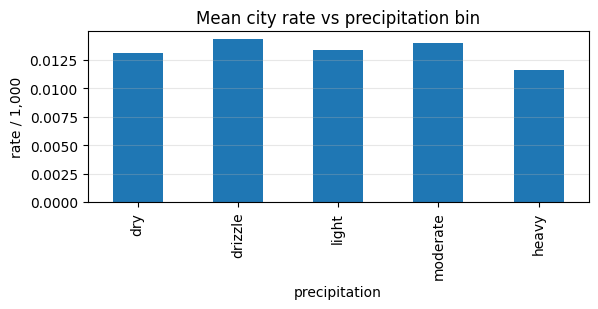

In [33]:
plt.figure(figsize=(6,3.2))
(cw.groupby("prec_bin")["rate"].mean().reindex(labels)).plot(kind="bar")
plt.title("Mean city rate vs precipitation bin")
plt.xlabel("precipitation")
plt.ylabel("rate / 1,000")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_mean_city_rate_vs_precipitation_bin.png")
)
plt.show()

#### Observations

* For `prec_bin=heavy` mean rate is lower
* Highest for `prec_bin={drizzle,moderate}`

### Temperature vs rate plot

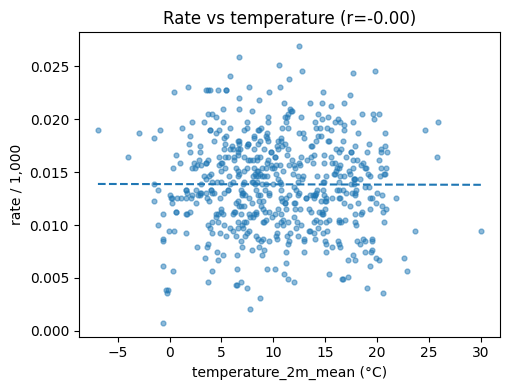

In [34]:
# 2) Scatter: температура vs rate (+ тренд и корреляция)
x = cw["temperature_2m_mean"]; y = cw["rate"]
mask = x.notna() & y.notna()
m, b = np.polyfit(x[mask], y[mask], 1)
r = x[mask].corr(y[mask])

plt.figure(figsize=(5.2,4))
plt.scatter(x[mask], y[mask], s=12, alpha=0.5)
xs = np.linspace(x[mask].min(), x[mask].max(), 100)
plt.plot(xs, m*xs + b, linestyle="--")
plt.title(f"Rate vs temperature (r={r:.2f})")
plt.xlabel("temperature_2m_mean (°C)")
plt.ylabel("rate / 1,000")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_rate_vs_temperature.png")
)
plt.show()

#### Observations

* There is no clear trend

### Rate vs sunshine

<Figure size 600x320 with 0 Axes>

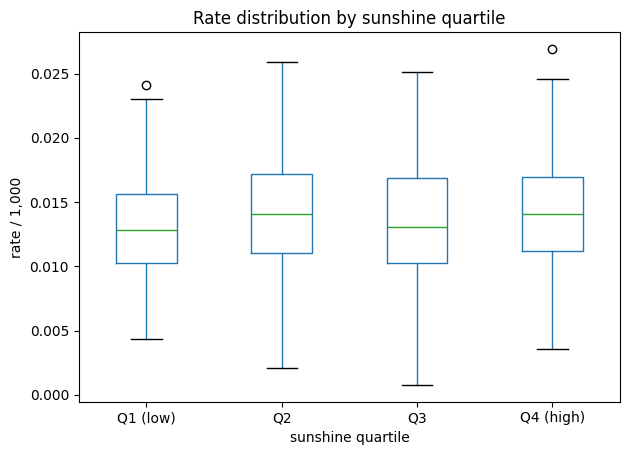

In [35]:
sun_q = pd.qcut(cw["sunshine_h"].fillna(0), 4, labels=["Q1 (low)","Q2","Q3","Q4 (high)"])
plt.figure(figsize=(6,3.2))
cw.assign(sun_q=sun_q).boxplot(column="rate", by="sun_q", grid=False)
plt.suptitle("")
plt.title("Rate distribution by sunshine quartile")
plt.xlabel("sunshine quartile")
plt.ylabel("rate / 1,000")
plt.savefig(
    os.path.join(FIGURES, "eda_rate_vs_sunshine.png")
)
plt.tight_layout()

#### Observations

* The more sunshine day is - the more chances of thefts

### Time overlay (rolling 7 days) vs precipitation

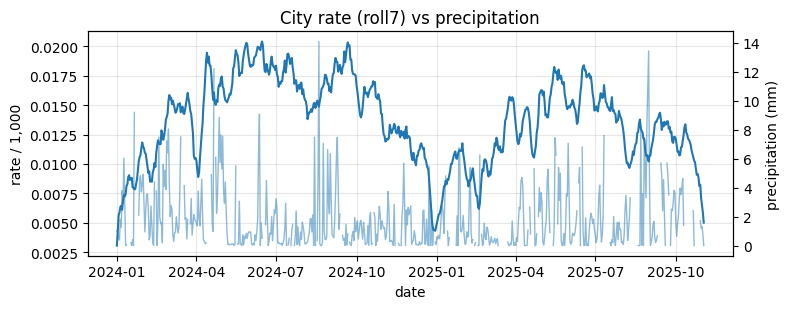

In [36]:

fig, ax1 = plt.subplots(figsize=(8,3.2))
ax1.plot(cw.index, cw["rate_roll7"], label="rate roll7", linewidth=1.5)
ax1.set_ylabel("rate / 1,000"); ax1.set_xlabel("date")
ax2 = ax1.twinx()
ax2.plot(cw.index, cw["precipitation_sum"], alpha=0.5, label="precipitation", linewidth=1)
ax2.set_ylabel("precipitation (mm)")
ax1.set_title("City rate (roll7) vs precipitation")
ax1.grid(alpha=0.3)
plt.savefig(
    os.path.join(FIGURES, "eda_mean_city_rate_roll_7d_vs_precipitation.png")
)
fig.tight_layout()
plt.show()

#### Observations

* Seasonal dependency:
  * Winter - lower
  * Sommer - higher
* Peak of `precipitation_sum` does not match with the growth/decline of `rate`

### Precipitation lag vs rate

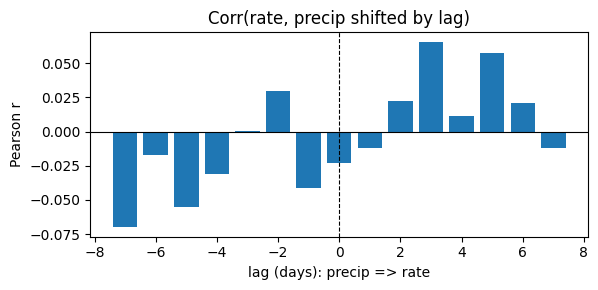

In [37]:
lags = range(-7, 8)
xcorr = [cw["rate"].corr(cw["precipitation_sum"].shift(l)) for l in lags]
plt.figure(figsize=(6,3))
plt.bar(lags, xcorr, width=0.8)
plt.axhline(0, color="k", linewidth=0.8)
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.title("Corr(rate, precip shifted by lag)")
plt.xlabel("lag (days): precip => rate")
plt.ylabel("Pearson r")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_lag_days_percipitation_to_rate.png")
)
plt.show()

#### Observations

* Not much of correlation
  * All correlations $|r| \leq 0.07$

## 6. Population and POI

### Prepare data

In [38]:
lor_area = df.groupby("lor")["area_km2"].first()
lor_pop = df.groupby("lor")["population_total"].first()
pop_density_km2 = (lor_pop / lor_area).rename("pop_density_km2")

rate_mean = daily.groupby("lor")["y_rate_per_1000"].mean().rename("rate_mean")
poi_density = df.groupby("lor")["poi_density_km2"].first()

X = pd.concat([rate_mean, pop_density_km2, poi_density], axis=1).dropna()

### Rate vs population density plot

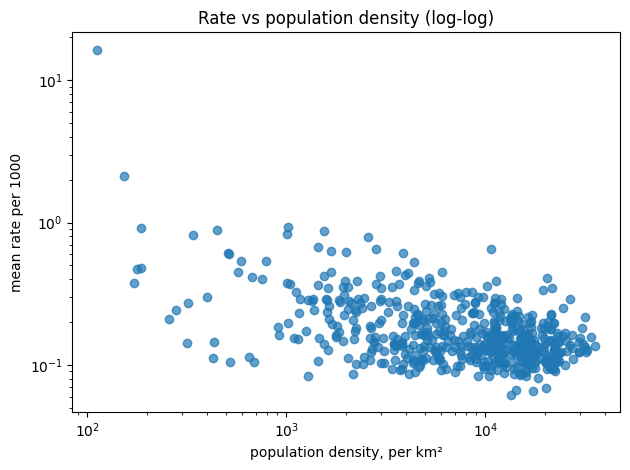

In [39]:
plt.figure()
plt.scatter(X["pop_density_km2"], X["rate_mean"], alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.title("Rate vs population density (log-log)")
plt.xlabel("population density, per km²")
plt.ylabel("mean rate per 1000")
plt.savefig(
    os.path.join(FIGURES, "eda_rate_vs_population_density_per_km.png")
)
plt.tight_layout()
plt.show()

#### Observations:

* The more LOR density population, the less thefts per 1000 inhabitants

### Rate vs POI density plot

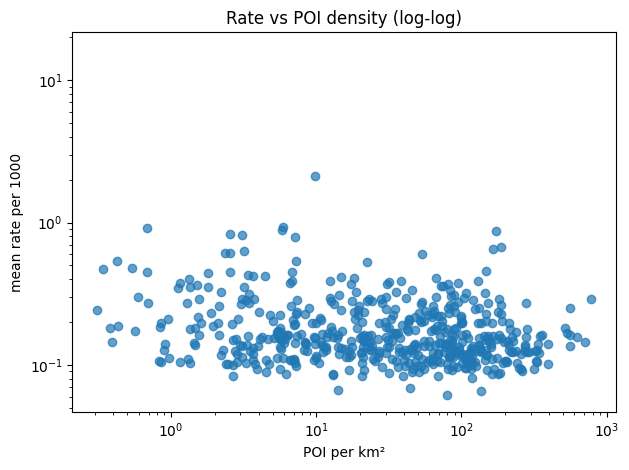

In [40]:
plt.figure()
plt.scatter(X["poi_density_km2"], X["rate_mean"], alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.title("Rate vs POI density (log-log)")
plt.xlabel("POI per km²")
plt.ylabel("mean rate per 1000")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_rate_vs_poi_density.png")
)
plt.show()

#### Observations:

* There is no monotonic dependency

## 7. Composition of thefts

### Prepare data

In [41]:
price_clip = df["price"].clip(upper=df["price"].quantile(0.99))
median_by_type = (df.groupby("bicycle_type")["price"]
                  .median().sort_values(ascending=False))

### Loss amount (price)

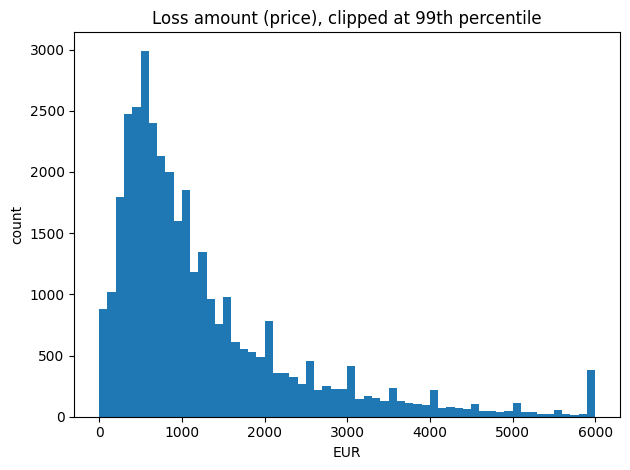

In [42]:
plt.figure()
price_clip.plot(kind="hist", bins=60)
plt.title("Loss amount (price), clipped at 99th percentile")
plt.xlabel("EUR")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_loss_amount_price.png")
)
plt.show()

In [43]:
print(f"Median damage is €{price_clip.median()}")

Median damage is €880.0


### Median loss by bicycle type

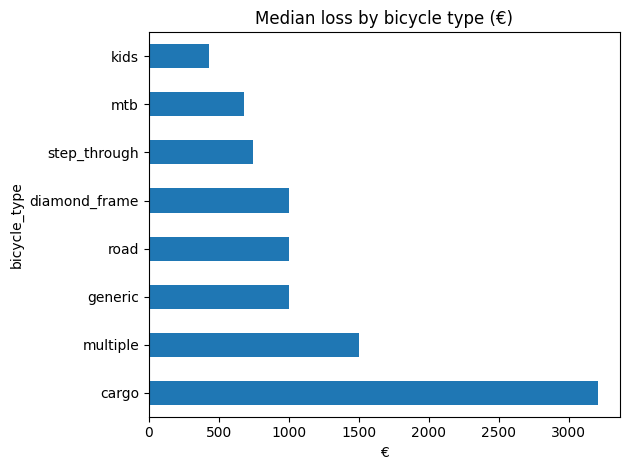

In [44]:
plt.figure()
median_by_type.plot(kind="barh")
plt.title("Median loss by bicycle type (€)")
plt.xlabel("€")
plt.ylabel("bicycle_type")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "eda_median_loss_by_bicycle_type.png")
)
plt.show()

### Observations:

1. Most of the thefts are in segment €0-1000
2. Cargo bycicles have the hightes median loss